In [1]:
from kan import *
import pytz
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train = loc_tz.localize(datetime.datetime(2015,3,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2015,3,15,0,0,0,0))

df_train = df.loc[(df.index <= split_date_train)].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# 输入标准化
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#输出标准化
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#测试集标准化
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))

In [3]:
from PyEMD import EMD
emd = EMD()
IMF = emd.emd(x_train_label.reshape(-1))

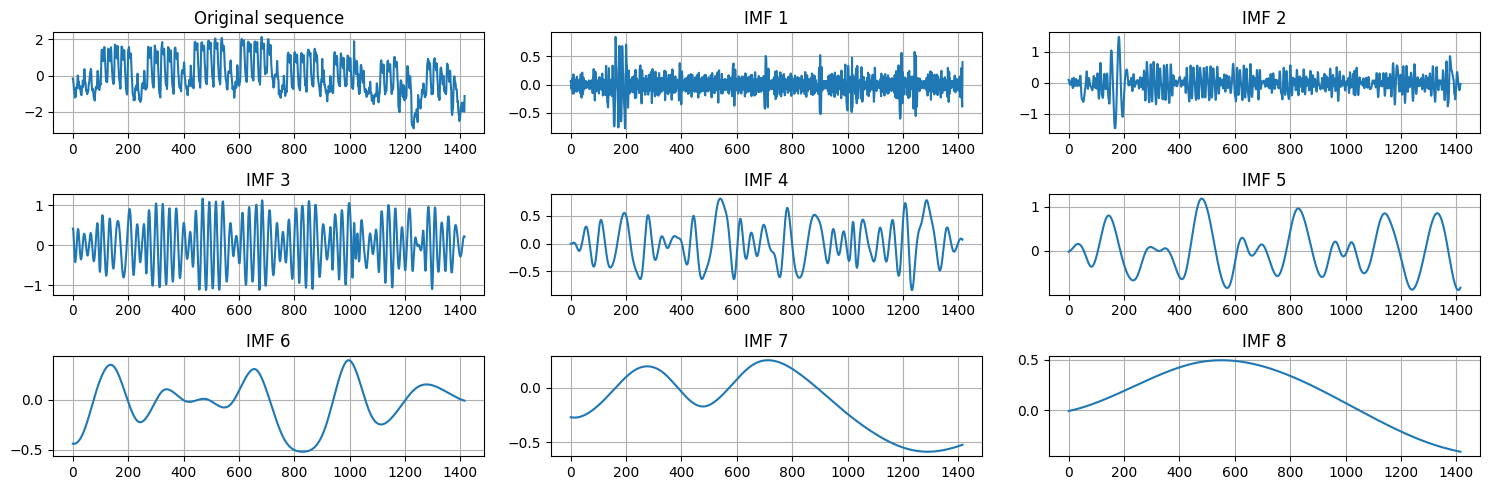

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(3,3,1)
plt.plot(x_train_label.reshape(-1))
plt.title("Original sequence")
plt.grid()
for i in range(IMF.shape[0]):
    plt.subplot(3,3,i+2)
    plt.plot(IMF[i])
    plt.title("IMF "+str(i+1))
    plt.grid()
plt.tight_layout()   
plt.show()

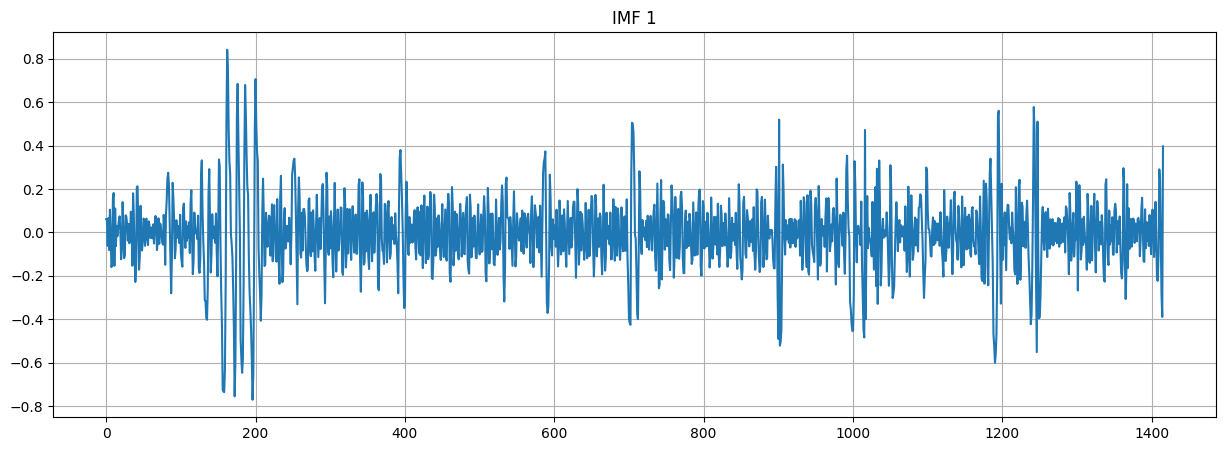

In [5]:
plt.figure(figsize=(15,5))
plt.plot(IMF[0])
plt.title("IMF "+str(1))
plt.grid()
plt.show()

In [13]:
_temp_train_input = np.hstack((x_train_input[:,:8],x_train_input[:,-3:-1]))[:(1416-280),:]
# _temp_train_label = IMF[2][:1136]

_temp_test_input = np.hstack((x_train_input[:,:8],x_train_input[:,-3:-1]))[-280:,:]
# _temp_test_label = IMF[2][-280:]


# _temp_train_input = x_train_input[:,-3:-1][:(1416-280),:]
_temp_train_label = IMF[0][:1136]

# _temp_test_input = x_train_input[:,-3:-1][-280:,:]
_temp_test_label = IMF[0][-280:]

# _temp_train_input = x_train_input[:,-3:-1][:(1416-280),:]
# _temp_train_label = x_train_label[:1136]

# _temp_test_input =  x_train_input[:,-3:-1][-280:,:]
# _temp_test_label = x_train_label[-280:]

# _temp_train_input = np.hstack((x_train_input[:,:8],x_train_input[:,-3:-1]))[:24*10,:]
# _temp_train_label = IMF[1][:24*10]

# _temp_test_input = np.hstack((x_train_input[:,:8],x_train_input[:,-3:-1]))[24*10:24*11,:]
# _temp_test_label = IMF[1][24*10:24*11]

dataset = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

# dataset['test_input'] = torch.tensor(np.array(X_test)[:,:32])
# dataset['test_label'] = torch.tensor(np.array(y_test))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_default_dtype(torch.float32)


In [15]:
# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/KAN_BaseConfig_SPRING.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]

Best_step = best_config[0].astype(int)
Best_lr = best_config[1]
Best_grid = best_config[2].astype(int)
Best_k = best_config[3].astype(int)
Best_internal_units = best_config[4].astype(int)
Best_batch = best_config[5].astype(int)
Best_lamb = best_config[6].astype(float)
Best_lamb_entropy = best_config[7].astype(float)

print("\nBest Configuration: Step: {}, Learning Rate: {}, Grid: {}, K: {}, Internal Units: {}, Batch Size: {}, Lamb: {}, Lamb Entropy: {}".format(Best_step, Best_lr, Best_grid, Best_k, Best_internal_units, Best_batch, Best_lamb, Best_lamb_entropy))


Best Configuration: Step: 100, Learning Rate: 0.01, Grid: 12, K: 3, Internal Units: 16, Batch Size: 64, Lamb: 0.01, Lamb Entropy: 10.0


In [26]:
model = KAN(width=[10, int(Best_internal_units), 1], grid=100, k=Best_k, auto_save=False, seed=0, device=device)
dataset = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

for i in range(Best_internal_units):
    model.fix_symbolic(0, 9, i, 'sin', fit_params_bool=False)
    model.fix_symbolic(0, 8, i, 'sin', fit_params_bool=False)
        
model.auto_save = True
# model.fit(dataset, opt="LBFGS", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr);
# , lamb=Best_lamb, lamb_entropy=Best_lamb_entropy

saving model version 0.1


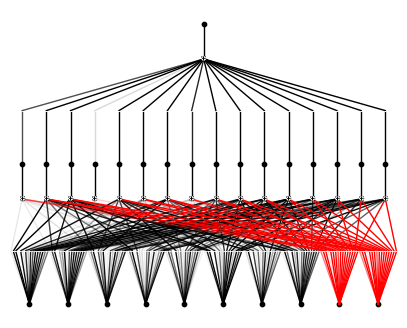

In [27]:
model.plot()

In [28]:
# results_df = pd.DataFrame(results_2)
# results_df.to_csv('./parameters_configuration/NN+KAN-SPIRNG.csv')  
# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/NN+KAN-SPIRNG.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]
Best_threshold_1 = best_config[0]
Best_threshold_2 = best_config[1]
print("\nBest Configuration: Best_threshold_1: {}, Best_threshold_2: {}".format(Best_threshold_1, Best_threshold_2))


Best Configuration: Best_threshold_1: 0.02, Best_threshold_2: 0.02


saving model version 0.1


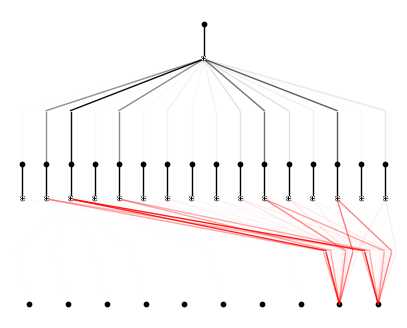

In [29]:
model = model.prune(node_th=Best_threshold_1, edge_th=Best_threshold_2);
model.auto_save = True
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.plot()

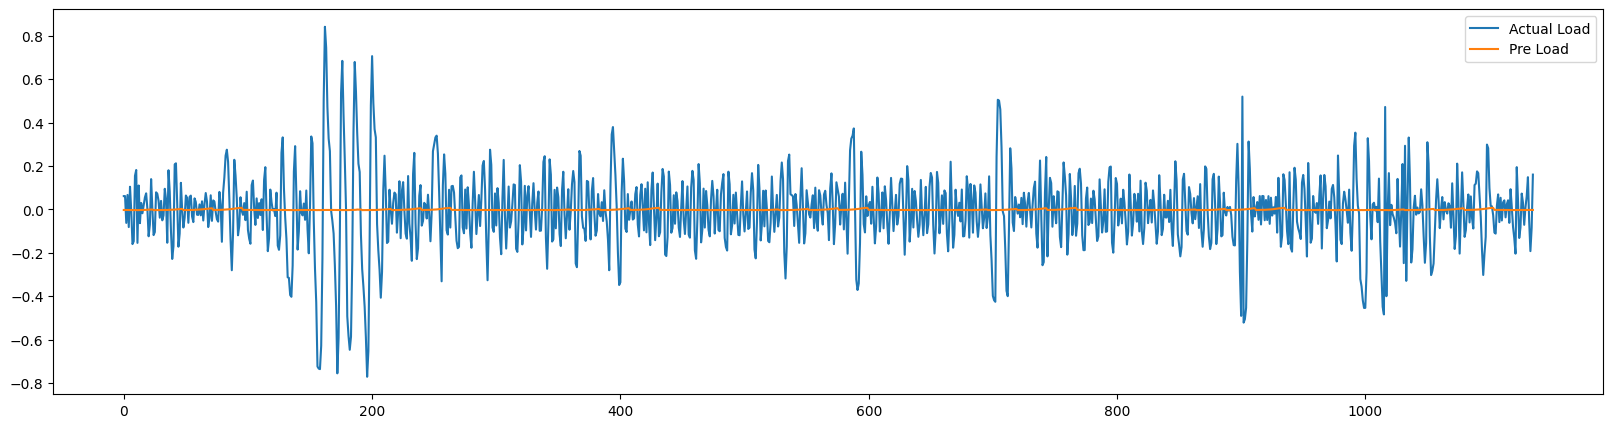

In [30]:
pre = model.forward(dataset['train_input'])
plt.figure(figsize=(20,5))
plt.plot(dataset['train_label'],label="Actual Load")
plt.plot(pre.detach().numpy(),label="Pre Load")
# plt.plot(pre.detach().numpy()-dataset['train_label'].detach().numpy())
# plt.ylim(6500,8000)
plt.legend()
plt.show()